In [2]:
!pip install torchinfo

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
import wandb
import gc
from torchinfo import summary
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

In [4]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {'values': [0.0001]},
        'batch_size': {'values': [8, 16, 64]},
        'num_epochs': {'values': [10, 20, 30]}
    }
}
sweep_id = wandb.sweep(sweep_config, project='alexnet_5_flower')

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 2bt358um
Sweep URL: https://wandb.ai/pro-laxmi-indian-institute-of-technology-gandhinagar/alexnet_5_flower/sweeps/2bt358um


In [5]:
def train():
    with wandb.init() as run:
        config = wandb.config

        learning_rate = config.learning_rate
        batch_size = config.batch_size
        num_epochs = config.num_epochs

        # Data Transformations
        path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
        
        image_size = 227
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        dataset_path = os.path.join(path, "flowers")
        dataset = ImageFolder(root=dataset_path, transform=transform)

        train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
        train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

        # Model declaration
        class AlexNet(nn.Module):
            def __init__(self, num_classes=5):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=3, stride=2),

                    nn.Conv2d(96, 256, kernel_size=5, padding=2),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=3, stride=2),

                    nn.Conv2d(256, 384, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),

                    nn.Conv2d(384, 384, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),

                    nn.Conv2d(384, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(256 * 6 * 6, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(),

                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(),

                    nn.Linear(4096, num_classes)
                )
            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x

        # Transferring on GPU for better results
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = AlexNet().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_values = []
        training_accuracy = []
        validation_accuracy = []

        # Training loop
        for epoch in range(num_epochs):
            # --- TRAINING PHASE ---
            model.train()  # Set model to training mode
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            
            for images, labels in train_dataset:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            avg_loss = running_loss / len(train_dataset)
            train_acc = correct_train / total_train
            
            loss_values.append(avg_loss)
            training_accuracy.append(train_acc)
            
            # --- VALIDATION PHASE ---
            model.eval()
            correct_val = 0
            total_val = 0
            
            with torch.no_grad():
                for images, labels in val_dataset:
                    images, labels = images.to(device), labels.to(device)
                    
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    
            val_acc = correct_val / total_val
            validation_accuracy.append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
            wandb.log({
                'epoch': epoch+1,
                'loss': avg_loss,
                'training_accuracy': train_acc,
                'validation_accuracy': val_acc
            })
        # Final evaluation on test data
        model.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_dataset:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
        test_acc = correct_test / total_test
        print(f"Test Accuracy: {test_acc:.4f}")
        wandb.log({'test_accuracy': test_acc})
        del model, optimizer, criterion, images, labels, outputs
        gc.collect()
        torch.cuda.empty_cache()
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: kmjwkrc6 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: Currently logged in as: pro-laxmi (pro-laxmi-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 225M/225M [00:01<00:00, 119MB/s]  

Extracting files...


Epoch [1/10], Loss: 1.4526, Training Accuracy: 0.3193, Validation Accuracy: 0.4014
Epoch [2/10], Loss: 1.1671, Training Accuracy: 0.5041, Validation Accuracy: 0.5568
Epoch [3/10], Loss: 1.0266, Training Accuracy: 0.5834, Validation Accuracy: 0.6288
Epoch [4/10], Loss: 0.9303, Training Accuracy: 0.6338, Validation Accuracy: 0.6357
Epoch [5/10], Loss: 0.8415, Training Accuracy: 0.6809, Validation Accuracy: 0.6891
Epoch [6/10], Loss: 0.7682, Training Accuracy: 0.6946, Validation Accuracy: 0.6473
Epoch [7/10], Loss: 0.7023, Training Accuracy: 0.7200, Validation Accuracy: 0.6961
Epoch [8/10], Loss: 0.6326, Training Accuracy: 0.7643, Validation Accuracy: 0.7262
Epoch [9/10], Loss: 0.5317, Training Accuracy: 0.7970, Validation Accuracy: 0.7123
Epoch [10/10], Loss: 0.4684, Training Accuracy: 0.8286, Validation Accuracy: 0.7100
Test Accuracy: 0.6690


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▃▂▁▁
test_accuracy,▁
training_accuracy,▁▄▅▅▆▆▇▇██
validation_accuracy,▁▄▆▆▇▆▇███
epoch,10
loss,0.46838
test_accuracy,0.66898
training_accuracy,0.8286
validation_accuracy,0.70998


wandb: Agent Starting Run: pjea49k5 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 20


Epoch [1/20], Loss: 1.3666, Training Accuracy: 0.3680, Validation Accuracy: 0.4408
Epoch [2/20], Loss: 1.1231, Training Accuracy: 0.5180, Validation Accuracy: 0.6009
Epoch [3/20], Loss: 0.9635, Training Accuracy: 0.6115, Validation Accuracy: 0.6497
Epoch [4/20], Loss: 0.8721, Training Accuracy: 0.6529, Validation Accuracy: 0.6775
Epoch [5/20], Loss: 0.8302, Training Accuracy: 0.6778, Validation Accuracy: 0.6914
Epoch [6/20], Loss: 0.7392, Training Accuracy: 0.7119, Validation Accuracy: 0.7146
Epoch [7/20], Loss: 0.6812, Training Accuracy: 0.7377, Validation Accuracy: 0.6937
Epoch [8/20], Loss: 0.5978, Training Accuracy: 0.7774, Validation Accuracy: 0.6381
Epoch [9/20], Loss: 0.5152, Training Accuracy: 0.8115, Validation Accuracy: 0.6868
Epoch [10/20], Loss: 0.4278, Training Accuracy: 0.8451, Validation Accuracy: 0.6868
Epoch [11/20], Loss: 0.3234, Training Accuracy: 0.8842, Validation Accuracy: 0.7193
Epoch [12/20], Loss: 0.2658, Training Accuracy: 0.9065, Validation Accuracy: 0.6845
E

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁
test_accuracy,▁
training_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇▇██████
validation_accuracy,▁▅▆▇▇█▇▆▇▇█▇█▇▇▇▇███
epoch,20
loss,0.10111
test_accuracy,0.7338
training_accuracy,0.97192
validation_accuracy,0.70534


wandb: Agent Starting Run: ub4jfuz1 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 30


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/30], Loss: 1.3399, Training Accuracy: 0.3877, Validation Accuracy: 0.5081
Epoch [2/30], Loss: 1.1207, Training Accuracy: 0.5417, Validation Accuracy: 0.5684
Epoch [3/30], Loss: 0.9698, Training Accuracy: 0.6283, Validation Accuracy: 0.6636
Epoch [4/30], Loss: 0.8682, Training Accuracy: 0.6610, Validation Accuracy: 0.7077
Epoch [5/30], Loss: 0.7921, Training Accuracy: 0.6925, Validation Accuracy: 0.7216
Epoch [6/30], Loss: 0.7212, Training Accuracy: 0.7279, Validation Accuracy: 0.6520
Epoch [7/30], Loss: 0.6487, Training Accuracy: 0.7614, Validation Accuracy: 0.6961
Epoch [8/30], Loss: 0.5780, Training Accuracy: 0.7869, Validation Accuracy: 0.7146
Epoch [9/30], Loss: 0.4894, Training Accuracy: 0.8211, Validation Accuracy: 0.6705
Epoch [10/30], Loss: 0.3983, Training Accuracy: 0.8564, Validation Accuracy: 0.6937
Epoch [11/30], Loss: 0.3292, Training Accuracy: 0.8836, Validation Accuracy: 0.7262
Epoch [12/3

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
training_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇▇▇███████████████
validation_accuracy,▁▃▆▇█▆▇█▆▇██▆▆▇▇▇▆█▆▇▇▇▇▇▆▇▆▇▅
epoch,30
loss,0.09481
test_accuracy,0.66204
training_accuracy,0.97105
validation_accuracy,0.64733


wandb: Agent Starting Run: j3iky1w7 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/10], Loss: 1.4030, Training Accuracy: 0.3665, Validation Accuracy: 0.5244
Epoch [2/10], Loss: 1.1122, Training Accuracy: 0.5249, Validation Accuracy: 0.5476
Epoch [3/10], Loss: 0.9681, Training Accuracy: 0.6086, Validation Accuracy: 0.5940
Epoch [4/10], Loss: 0.8875, Training Accuracy: 0.6517, Validation Accuracy: 0.5476
Epoch [5/10], Loss: 0.8065, Training Accuracy: 0.6899, Validation Accuracy: 0.7030
Epoch [6/10], Loss: 0.7272, Training Accuracy: 0.7229, Validation Accuracy: 0.6845
Epoch [7/10], Loss: 0.6796, Training Accuracy: 0.7391, Validation Accuracy: 0.6729
Epoch [8/10], Loss: 0.6052, Training Accuracy: 0.7771, Validation Accuracy: 0.7355
Epoch [9/10], Loss: 0.5213, Training Accuracy: 0.8089, Validation Accuracy: 0.7169
Epoch [10/10], Loss: 0.4985, Training Accuracy: 0.8118, Validation Accuracy: 0.7193
Test Accuracy: 0.7593


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
test_accuracy,▁
training_accuracy,▁▃▅▅▆▇▇▇██
validation_accuracy,▁▂▃▂▇▆▆█▇▇
epoch,10
loss,0.49852
test_accuracy,0.75926
training_accuracy,0.81181
validation_accuracy,0.71926


wandb: Agent Starting Run: wmmtld5n with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 20


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/20], Loss: 1.3525, Training Accuracy: 0.3796, Validation Accuracy: 0.4849
Epoch [2/20], Loss: 1.1045, Training Accuracy: 0.5368, Validation Accuracy: 0.5754
Epoch [3/20], Loss: 0.9893, Training Accuracy: 0.6129, Validation Accuracy: 0.6102
Epoch [4/20], Loss: 0.8834, Training Accuracy: 0.6534, Validation Accuracy: 0.6450
Epoch [5/20], Loss: 0.8027, Training Accuracy: 0.7012, Validation Accuracy: 0.7030
Epoch [6/20], Loss: 0.7345, Training Accuracy: 0.7212, Validation Accuracy: 0.6798
Epoch [7/20], Loss: 0.6762, Training Accuracy: 0.7446, Validation Accuracy: 0.6984
Epoch [8/20], Loss: 0.6101, Training Accuracy: 0.7664, Validation Accuracy: 0.7100
Epoch [9/20], Loss: 0.5317, Training Accuracy: 0.8037, Validation Accuracy: 0.7100
Epoch [10/20], Loss: 0.4680, Training Accuracy: 0.8243, Validation Accuracy: 0.7216
Epoch [11/20], Loss: 0.4058, Training Accuracy: 0.8529, Validation Accuracy: 0.7169
Epoch [12/2

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▁▂▁▁▁
test_accuracy,▁
training_accuracy,▁▃▄▄▅▅▅▅▆▆▆▇▇▇▇█████
validation_accuracy,▁▃▄▅▇▆▇▇▇▇▇▆█▆▆▇▇▇██
epoch,20
loss,0.0331
test_accuracy,0.74074
training_accuracy,0.99334
validation_accuracy,0.75638


wandb: Agent Starting Run: yk1vjjof with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 30


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/30], Loss: 1.3777, Training Accuracy: 0.3798, Validation Accuracy: 0.5197
Epoch [2/30], Loss: 1.1434, Training Accuracy: 0.5162, Validation Accuracy: 0.5916
Epoch [3/30], Loss: 1.0047, Training Accuracy: 0.5903, Validation Accuracy: 0.6404
Epoch [4/30], Loss: 0.9030, Training Accuracy: 0.6474, Validation Accuracy: 0.6775
Epoch [5/30], Loss: 0.8230, Training Accuracy: 0.6844, Validation Accuracy: 0.7123
Epoch [6/30], Loss: 0.7541, Training Accuracy: 0.7166, Validation Accuracy: 0.7077
Epoch [7/30], Loss: 0.6891, Training Accuracy: 0.7380, Validation Accuracy: 0.7285
Epoch [8/30], Loss: 0.6288, Training Accuracy: 0.7603, Validation Accuracy: 0.7425
Epoch [9/30], Loss: 0.5528, Training Accuracy: 0.7901, Validation Accuracy: 0.7471
Epoch [10/30], Loss: 0.4861, Training Accuracy: 0.8211, Validation Accuracy: 0.6613
Epoch [11/30], Loss: 0.4287, Training Accuracy: 0.8364, Validation Accuracy: 0.7541
Epoch [12/3

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
training_accuracy,▁▃▃▄▄▅▅▅▆▆▆▇▇▇▇███████████████
validation_accuracy,▁▃▄▅▆▆▇▇▇▅▇███▇▇██▇█▇▇▇█▇▇████
epoch,30
loss,0.03431
test_accuracy,0.73611
training_accuracy,0.99045
validation_accuracy,0.77262


wandb: Agent Starting Run: yrq1lxf9 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/10], Loss: 1.4499, Training Accuracy: 0.3477, Validation Accuracy: 0.4548
Epoch [2/10], Loss: 1.1823, Training Accuracy: 0.4997, Validation Accuracy: 0.4965
Epoch [3/10], Loss: 1.0663, Training Accuracy: 0.5449, Validation Accuracy: 0.5545
Epoch [4/10], Loss: 1.0250, Training Accuracy: 0.5816, Validation Accuracy: 0.5661
Epoch [5/10], Loss: 0.9378, Training Accuracy: 0.6204, Validation Accuracy: 0.6148
Epoch [6/10], Loss: 0.8466, Training Accuracy: 0.6636, Validation Accuracy: 0.6311
Epoch [7/10], Loss: 0.7932, Training Accuracy: 0.6867, Validation Accuracy: 0.6520
Epoch [8/10], Loss: 0.7523, Training Accuracy: 0.7009, Validation Accuracy: 0.7030
Epoch [9/10], Loss: 0.6652, Training Accuracy: 0.7475, Validation Accuracy: 0.6845
Epoch [10/10], Loss: 0.6481, Training Accuracy: 0.7606, Validation Accuracy: 0.7030
Test Accuracy: 0.7222


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▁▁
test_accuracy,▁
training_accuracy,▁▄▄▅▆▆▇▇██
validation_accuracy,▁▂▄▄▆▆▇█▇█
epoch,10
loss,0.6481
test_accuracy,0.72222
training_accuracy,0.76057
validation_accuracy,0.70302


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3vgzso6h with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 20


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/20], Loss: 1.3939, Training Accuracy: 0.3668, Validation Accuracy: 0.4872
Epoch [2/20], Loss: 1.1374, Training Accuracy: 0.4986, Validation Accuracy: 0.5058
Epoch [3/20], Loss: 1.0484, Training Accuracy: 0.5602, Validation Accuracy: 0.5429
Epoch [4/20], Loss: 0.9809, Training Accuracy: 0.5941, Validation Accuracy: 0.5870
Epoch [5/20], Loss: 0.8992, Training Accuracy: 0.6433, Validation Accuracy: 0.6381
Epoch [6/20], Loss: 0.8228, Training Accuracy: 0.6778, Validation Accuracy: 0.6381
Epoch [7/20], Loss: 0.7546, Training Accuracy: 0.7064, Validation Accuracy: 0.6543
Epoch [8/20], Loss: 0.7026, Training Accuracy: 0.7412, Validation Accuracy: 0.6984
Epoch [9/20], Loss: 0.6346, Training Accuracy: 0.7626, Validation Accuracy: 0.6845
Epoch [10/20], Loss: 0.5966, Training Accuracy: 0.7753, Validation Accuracy: 0.7123
Epoch [11/20], Loss: 0.5339, Training Accuracy: 0.8028, Validation Accuracy: 0.7146
Epoch [12/2

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁
test_accuracy,▁
training_accuracy,▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇███
validation_accuracy,▁▁▂▄▅▅▅▆▆▇▇█▇▇█▇▇▇▇▆
epoch,20
loss,0.14145
test_accuracy,0.74769
training_accuracy,0.94876
validation_accuracy,0.69838


wandb: Agent Starting Run: 9c9p8ktl with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 30


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/30], Loss: 1.3976, Training Accuracy: 0.3344, Validation Accuracy: 0.4014
Epoch [2/30], Loss: 1.1953, Training Accuracy: 0.4682, Validation Accuracy: 0.4780
Epoch [3/30], Loss: 1.0836, Training Accuracy: 0.5382, Validation Accuracy: 0.5661
Epoch [4/30], Loss: 1.0215, Training Accuracy: 0.5666, Validation Accuracy: 0.5638
Epoch [5/30], Loss: 0.9319, Training Accuracy: 0.6146, Validation Accuracy: 0.6102
Epoch [6/30], Loss: 0.8310, Training Accuracy: 0.6708, Validation Accuracy: 0.6334
Epoch [7/30], Loss: 0.7774, Training Accuracy: 0.6977, Validation Accuracy: 0.6450
Epoch [8/30], Loss: 0.7460, Training Accuracy: 0.7148, Validation Accuracy: 0.6821
Epoch [9/30], Loss: 0.7016, Training Accuracy: 0.7247, Validation Accuracy: 0.6589
Epoch [10/30], Loss: 0.6135, Training Accuracy: 0.7690, Validation Accuracy: 0.6845
Epoch [11/30], Loss: 0.6109, Training Accuracy: 0.7710, Validation Accuracy: 0.7100
Epoch [12/3

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test_accuracy,▁
training_accuracy,▁▂▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████████
validation_accuracy,▁▃▄▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇█▇█▇████
epoch,30
loss,0.06261
test_accuracy,0.73611
training_accuracy,0.98031
validation_accuracy,0.74942


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Dataset_Preparation and Sampling

In [7]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.0001
num_epochs = 15
image_size = 227
hidden_nodes = 128

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)

Using Colab cache for faster access to the 'flowers-recognition' dataset.


In [8]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AlexNet().to(device)
summary(model)  # Great whay to look overall what is hapening inside your model

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       34,944
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       614,656
│    └─ReLU: 2-5                         --
│    └─Conv2d: 2-6                       885,120
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       1,327,488
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      884,992
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─Sequential: 1-2                        --
│    └─Flatten: 2-14                     --
│    └─Linear: 2-15                      37,752,832
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                  

## Correct and optimised training loop

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_values = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/15] | Loss: 1.3875 | Train Acc: 0.3639 | Val Acc: 0.4710
Epoch [2/15] | Loss: 1.1308 | Train Acc: 0.5324 | Val Acc: 0.5940
Epoch [3/15] | Loss: 0.9736 | Train Acc: 0.6155 | Val Acc: 0.6404
Epoch [4/15] | Loss: 0.8711 | Train Acc: 0.6746 | Val Acc: 0.6798
Epoch [5/15] | Loss: 0.8241 | Train Acc: 0.6928 | Val Acc: 0.6613
Epoch [6/15] | Loss: 0.7490 | Train Acc: 0.7209 | Val Acc: 0.6636
Epoch [7/15] | Loss: 0.7087 | Train Acc: 0.7374 | Val Acc: 0.6798
Epoch [8/15] | Loss: 0.6352 | Train Acc: 0.7603 | Val Acc: 0.6868
Epoch [9/15] | Loss: 0.5687 | Train Acc: 0.7895 | Val Acc: 0.7193
Epoch [10/15] | Loss: 0.4860 | Train Acc: 0.8156 | Val Acc: 0.7169
Epoch [11/15] | Loss: 0.4178 | Train Acc: 0.8500 | Val Acc: 0.7077
Epoch [12/15] | Loss: 0.3429 | Train Acc: 0.8775 | Val Acc: 0.7123
Epoch [13/15] | Loss: 0.2735 | Train Acc: 0.9074 | Val Acc: 0.7053
Epoch [14/15] | Loss: 0.2215 | Train Acc: 0.9204 | Val Acc: 0.6868
Epoch [15/15] | Loss: 0.1698 | Train Acc: 0.9433 | Val Acc: 0.6891


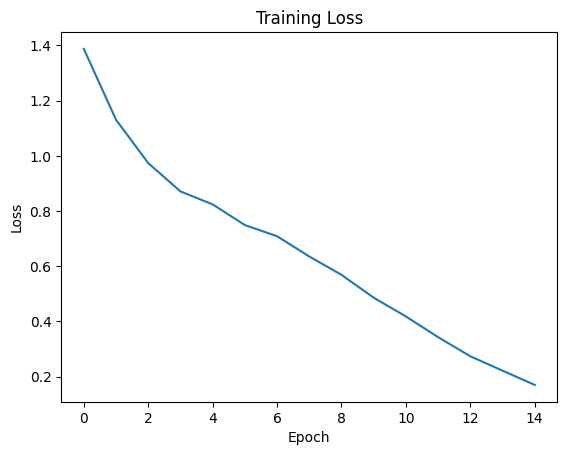

In [11]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

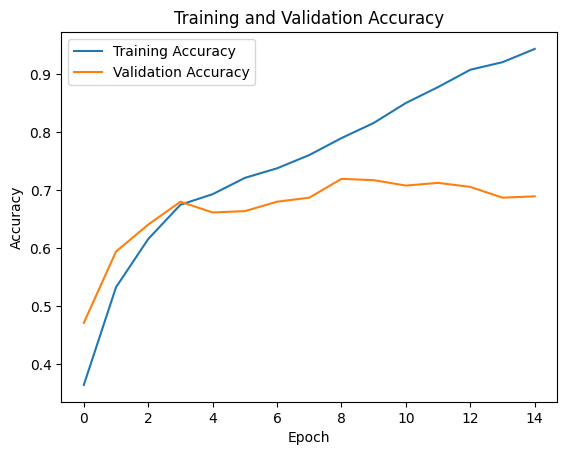

In [12]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [13]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")
print(f"Final train Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final validation Accuracy: {validation_accuracy[-1]:.4f}")

Overall test Accuracy: 0.6921
Final train Accuracy: 0.9433
Final validation Accuracy: 0.6891


In [27]:
import gc
del model, optimizer, criterion, images, labels, outputs
gc.collect()
torch.cuda.empty_cache()

We can clearly see a significant improvement in accuracy after fine-tuning MobileNet. While a simple deep neural network approach was struggling to reach meaningful performance, fine-tuning gives us a substantial jump in both training and validation metrics. The training accuracy reaches nearly 98.8%, indicating that the model is fitting the training data extremely well.

At the same time, the validation accuracy is around 94.2%, and the overall test accuracy is 91.9%, which shows strong generalization to unseen data. This gap between training and validation/test accuracy is reasonable, reflecting a little overfitting but still very solid performance.

The results demonstrate the power of fine-tuning pretrained networks: the pretrained MobileNet features adapt efficiently to our specific task without needing to train from scratch, and careful learning rate management ensures the model learns effectively without catastrophic forgetting. Overall, the performance boost is substantial and highlights the effectiveness of transfer learning in this scenario.